# nrt cross-calibrate

This notebook searches for nearby SMHI CTD profiles and Argo floats to use for cross-calibration of glider datasets

In [1]:
import utils
import pandas as pd
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import gsw
import ast
plt.rcParams.update({'font.size': 14})

### 1. Download all VOTO nrt datasets

In [2]:
nrt_dataset_ids = utils.find_glider_datasets()
glider_datasets = utils.download_glider_dataset(nrt_dataset_ids)


In [3]:
dataset_match_df = pd.DataFrame({"smhi":False, "argo":False}, index=nrt_dataset_ids)

### 2. Download SMHI data

**N.B.** this is a cached dataset last updated 2022-08-23. For a more up to date datasets, go to [sharkweb](https://sharkweb.smhi.se/hamta-data/)

In [4]:
smhi_df = pd.read_csv("https://callumrollo.com/nextcloud/index.php/s/bxBc7QGixQE5kd3/download/sharkweb_physical.txt",
                   sep=";",parse_dates=['Sampling date'], low_memory=False)
stations_df = smhi_df.groupby('ID Monitoring station').first()

smhi_df["station_visit"] = smhi_df['ID Monitoring station'] * 100000 + smhi_df['Visit event identifier']
station_visit_df =  smhi_df.groupby('station_visit').first()

### 3. Search for nearby smhi profiles

In [5]:
smhi_datasets = {}
for name, ds in glider_datasets.items():
    print(f"Trying dataset {name}")

    nearest_smhi_df = utils.nearest_smhi_station(smhi_df, station_visit_df, ds, lat_window=1, lon_window=2,
                                                 time_window=np.timedelta64(15, "D"))
    smhi_datasets[name] = nearest_smhi_df
    if nearest_smhi_df is not None:
        dataset_match_df.loc[name, "smhi"] = True

Trying dataset nrt_SEA068_M27
Nearest station profile is 14.6 km W, 103.4 km N & 337.7 hours later than mean of glider data
Trying dataset nrt_SEA069_M9
Nearest station profile is 15.4 km W, 102.7 km N & 347.9 hours later than mean of glider data
Trying dataset nrt_SEA055_M24
Nearest station profile is 21.0 km E, 19.1 km N & 110.6 hours later than mean of glider data
Trying dataset nrt_SEA055_M31
Nearest station profile is 97.7 km E, 7.4 km N & 61.5 hours later than mean of glider data
Trying dataset nrt_SEA055_M33
Nearest station profile is 80.4 km W, 94.0 km N & 295.1 hours earlier than mean of glider data
Trying dataset nrt_SEA055_M35
Nearest station profile is 1.4 km E, 41.7 km S & 282.9 hours later than mean of glider data
Trying dataset nrt_SEA055_M37
Nearest station profile is 23.7 km E, 20.4 km N & 219.0 hours earlier than mean of glider data
Trying dataset nrt_SEA055_M39
Nearest station profile is 19.3 km E, 47.8 km S & 268.6 hours later than mean of glider data
Trying dataset

### Search for nearby Argo profiles

For datasets with no nearby CTD station, look for Argo floats

In [6]:
argo_datasets = {}
for name, ds in glider_datasets.items():
    print(f"Trying dataset {name}")
    nearest_argo_ds = utils.nearest_argo_profile(ds, lat_window=1, lon_window=2)
    argo_datasets[name] = nearest_argo_ds
    if nearest_argo_ds:
         dataset_match_df.loc[name, "argo"] = True
        

Trying dataset nrt_SEA068_M27
Nearest float is 9.7 km E, 109.2 km S & 12.5 hours later than mean of glider data
Trying dataset nrt_SEA069_M9
Nearest float is 10.6 km E, 108.6 km S & 2.3 hours later than mean of glider data
Trying dataset nrt_SEA055_M24
Nearest float is 13.2 km W, 8.7 km S & 17.9 hours later than mean of glider data
Trying dataset nrt_SEA055_M31
Nearest float is 23.9 km W, 3.9 km N & 21.2 hours earlier than mean of glider data
Trying dataset nrt_SEA055_M33
No floats found within tolerances
Trying dataset nrt_SEA055_M35
No floats found within tolerances
Trying dataset nrt_SEA055_M37
Nearest float is 17.0 km E, 4.8 km N & 4.5 hours later than mean of glider data
Trying dataset nrt_SEA055_M39
No floats found within tolerances
Trying dataset nrt_SEA055_M41
No floats found within tolerances
Trying dataset nrt_SEA055_M43
Nearest float is 34.1 km E, 33.9 km N & 20.6 hours later than mean of glider data
Trying dataset nrt_SEA045_M54
Nearest float is 11.2 km W, 11.3 km N & 9.5 h

In [7]:
dataset_match_df["any_match"] = dataset_match_df.argo + dataset_match_df.smhi
print(f"For {len(dataset_match_df)} datasets found {sum(dataset_match_df.smhi)} SMHI matches,",
      f"{sum(dataset_match_df.argo)} Argo matches. {sum(~dataset_match_df.any_match)} datasets have no match")

For 39 datasets found 31 SMHI matches, 24 Argo matches. 4 datasets have no match


In [8]:
print(dataset_match_df)

                 smhi   argo  any_match
nrt_SEA068_M27   True   True       True
nrt_SEA069_M9    True   True       True
nrt_SEA055_M24   True   True       True
nrt_SEA055_M31   True   True       True
nrt_SEA055_M33   True  False       True
nrt_SEA055_M35   True  False       True
nrt_SEA055_M37   True   True       True
nrt_SEA055_M39   True  False       True
nrt_SEA055_M41   True  False       True
nrt_SEA055_M43  False   True       True
nrt_SEA045_M54   True   True       True
nrt_SEA045_M56   True   True       True
nrt_SEA045_M60   True  False       True
nrt_SEA045_M62   True   True       True
nrt_SEA045_M64  False   True       True
nrt_SEA045_M65  False   True       True
nrt_SEA063_M33   True   True       True
nrt_SEA063_M35   True   True       True
nrt_SEA063_M37   True   True       True
nrt_SEA063_M38   True   True       True
nrt_SEA063_M39   True  False       True
nrt_SEA063_M40  False   True       True
nrt_SEA044_M48   True   True       True
nrt_SEA067_M26   True   True       True


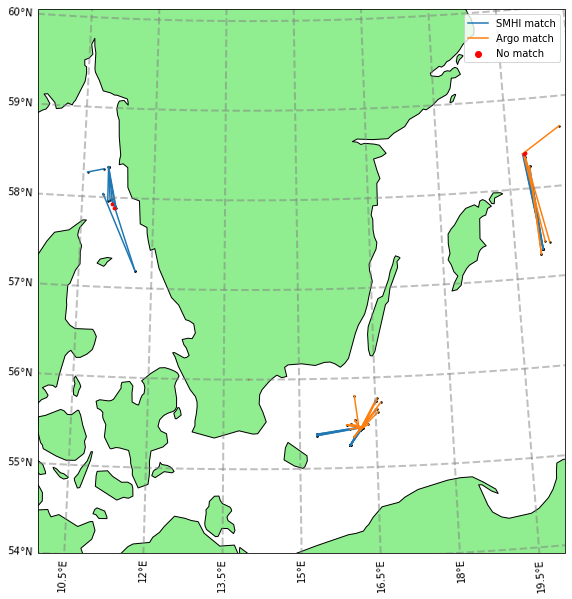

In [9]:
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=14, central_latitude=56)
pc = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=coord)
ax.set_extent([10, 20, 54, 60], crs=pc)

feature = cartopy.feature.NaturalEarthFeature(name='land', category='physical',
                                              scale='50m', edgecolor='black', facecolor='lightgreen')
ax.add_feature(feature)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = None
gl.right_labels = None

for name, df_smhi in smhi_datasets.items():
    ds_glider = glider_datasets[name]
    if df_smhi is not None:
        lon = [df_smhi['Sample longitude (DD)'].values[0], np.nanmean(ds_glider.longitude)]
        lat = [df_smhi['Sample latitude (DD)'].values[0], np.nanmean(ds_glider.latitude)]
        ax.scatter(lon, lat, transform=pc, s=2, color="k")
        ax.plot(lon, lat, transform=pc, color="C0")
        
for name, ds_argo in argo_datasets.items():
    ds_glider = glider_datasets[name]
    if ds_argo:
        lon = [ds_argo.LONGITUDE, np.nanmean(ds_glider.longitude)]
        lat = [ds_argo.LATITUDE, np.nanmean(ds_glider.latitude)]
        ax.scatter(lon, lat, transform=pc, s=2, color="k")
        ax.plot(lon, lat, transform=pc, color="C1")

dataset_ids_no_match = dataset_match_df[~dataset_match_df.any_match].index

for name in dataset_ids_no_match:
    ds_glider = glider_datasets[name]
    ax.scatter(np.nanmean(ds_glider.longitude), np.nanmean(ds_glider.latitude),transform=pc, s=8, color="red", zorder=10)    

ax.plot((0,1), (0,1),color="C0", label="SMHI match")       
ax.plot((0,1), (0,1),color="C1", label="Argo match")
ax.scatter((0,1), (0,1),color="red", label="No match")

ax.legend()
fig.savefig(f"figures/match_map.png")


### 4. Create comparative scatters

**Check dissolved oxygen conversion**

In [10]:
def oxy_ml_per_l_to_umol_per_m3(oxy_ml_l):
    """
    Old: 10mL dissolved O2 /L is about 13.3 mg/l http://rainbow.ldeo.columbia.edu/dl/QA/43.html
    New: mL L = mg L * (1 mL / 1.42903 mg) https://ogsl.ca/wp-content/uploads/Unit_conversions_en_0.pdf
    molar mass oxygen 15.9994 g/mol https://www.convertunits.com/molarmass/Oxygen
    """
    oxy_mg_l = oxy_ml_l * 1.42903 # or should it be 1.429?
    oxy_mmol_l = oxy_mg_l  / (15.9994 * 2)
    oxy_umol_l = oxy_mmol_l * 1e3
    oxy_umol_m3 = oxy_umol_l # * 1e3
    return oxy_umol_m3
oxy_ml_per_l_to_umol_per_m3 = np.vectorize(oxy_ml_per_l_to_umol_per_m3)


/tmp/ipykernel_10341/1283490272.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3, sharey="row", figsize=(12, 9))


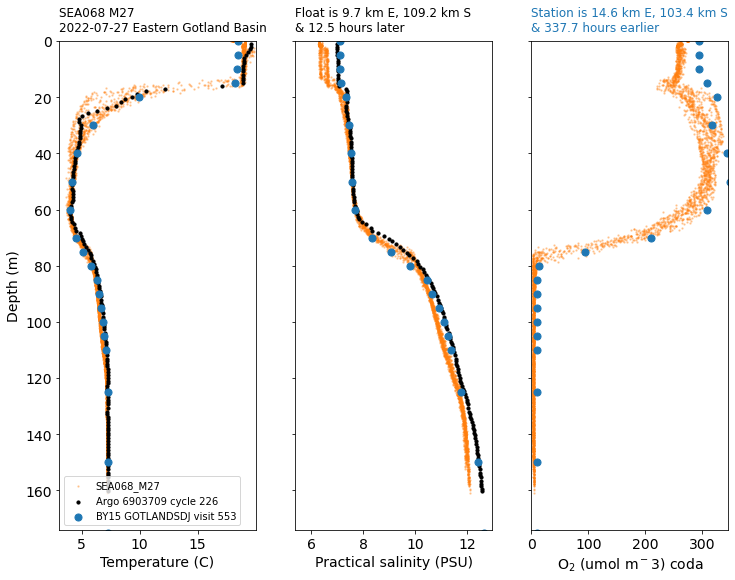

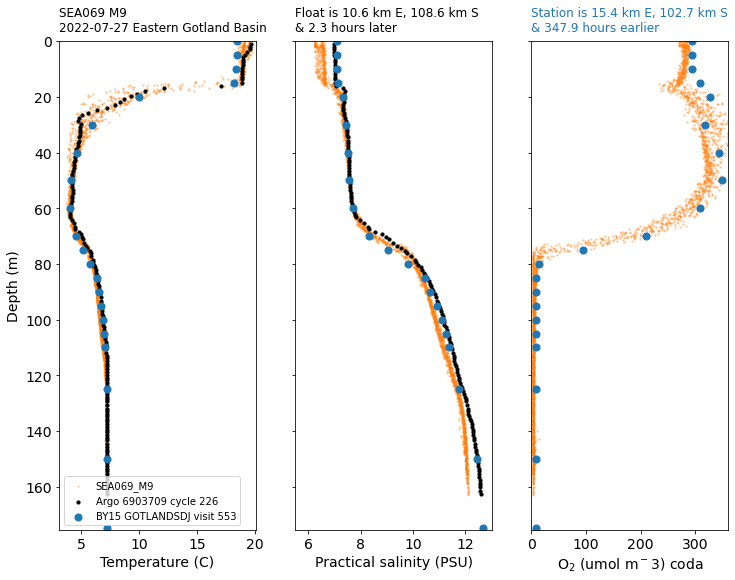

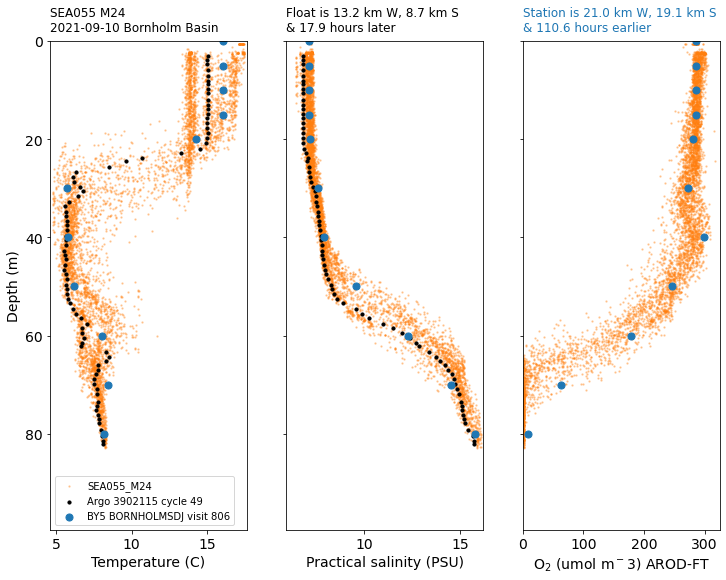

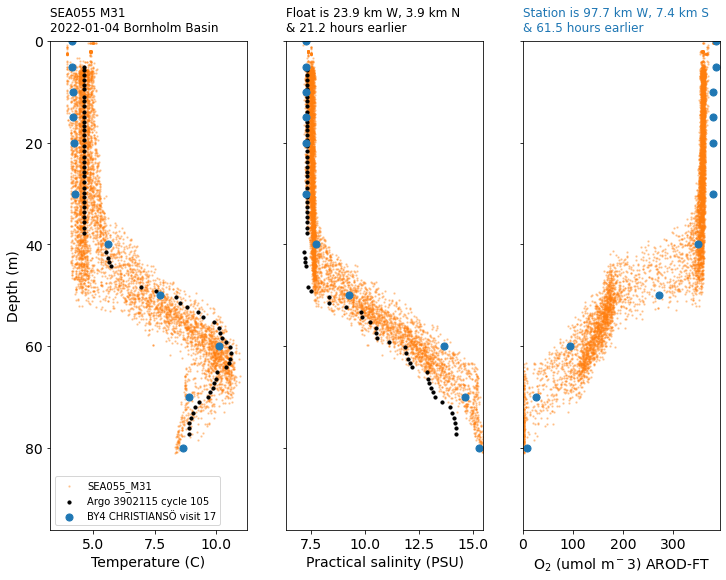

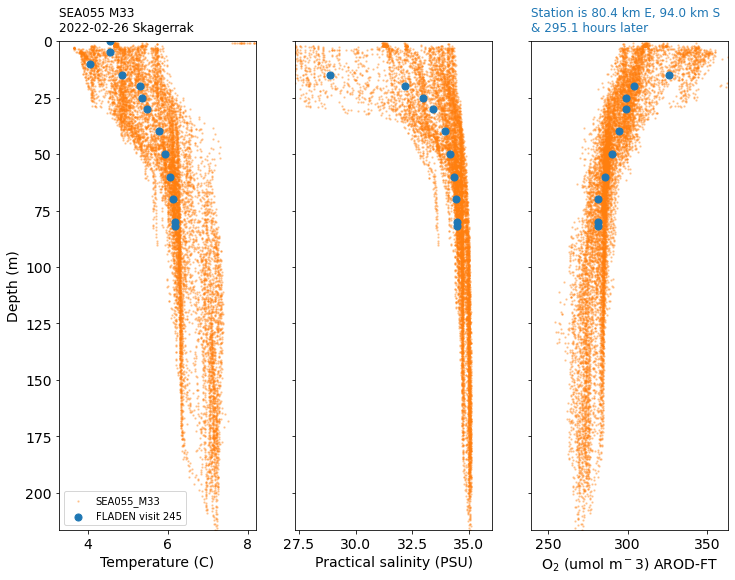

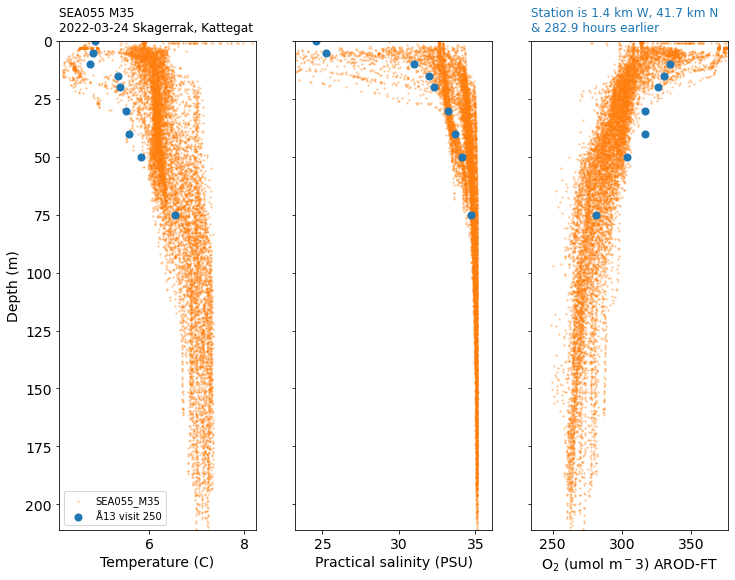

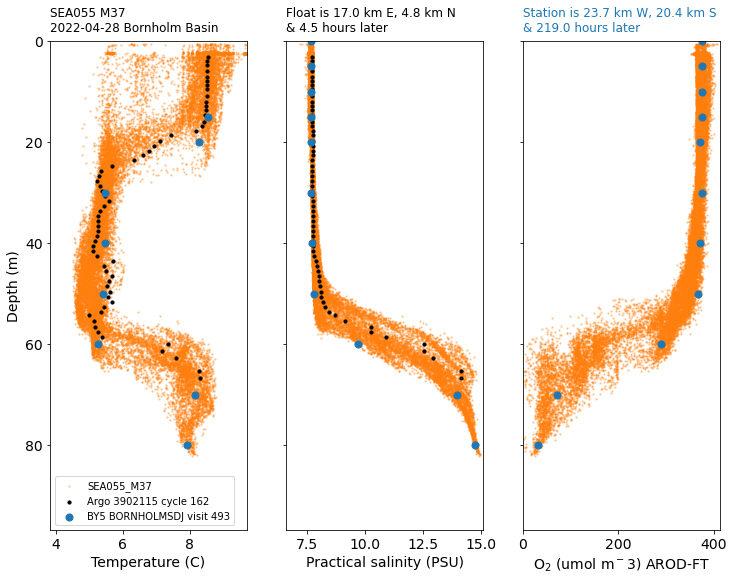

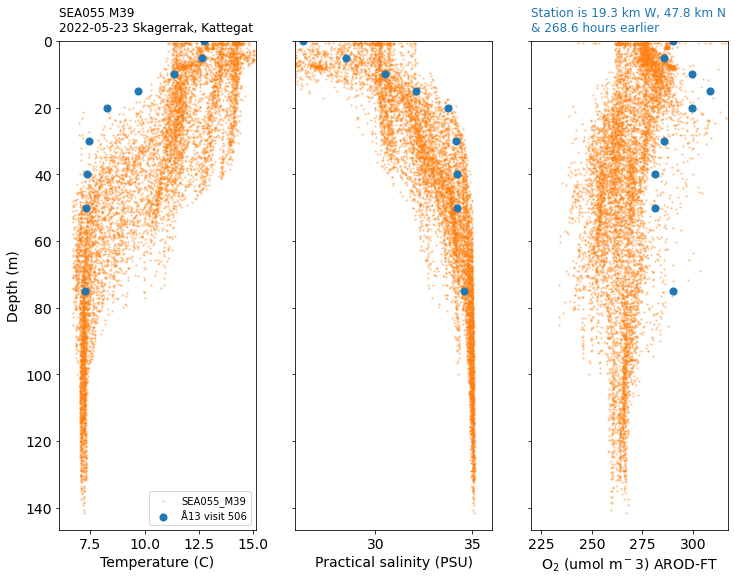

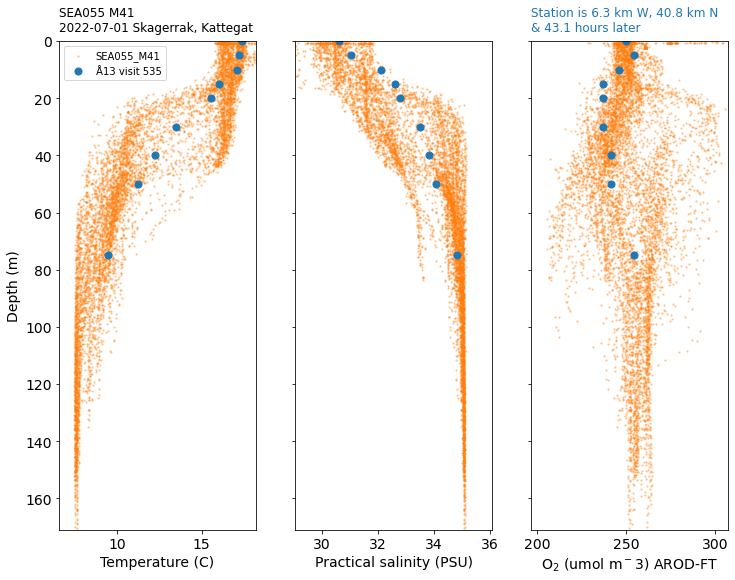

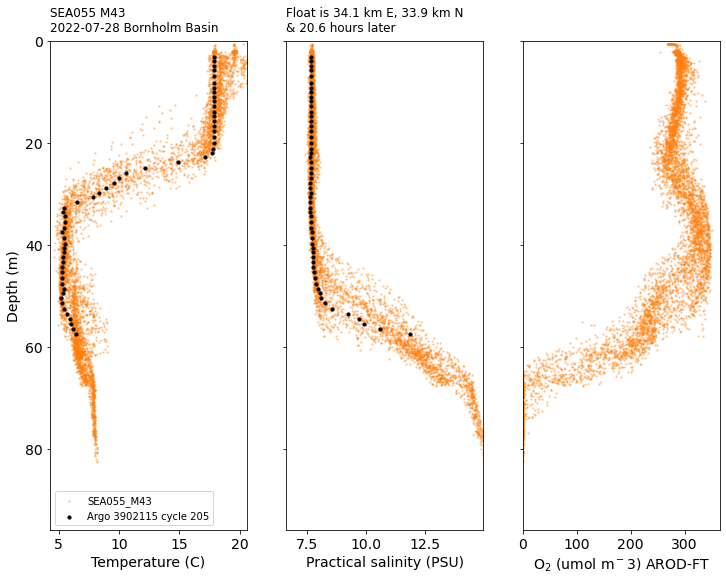

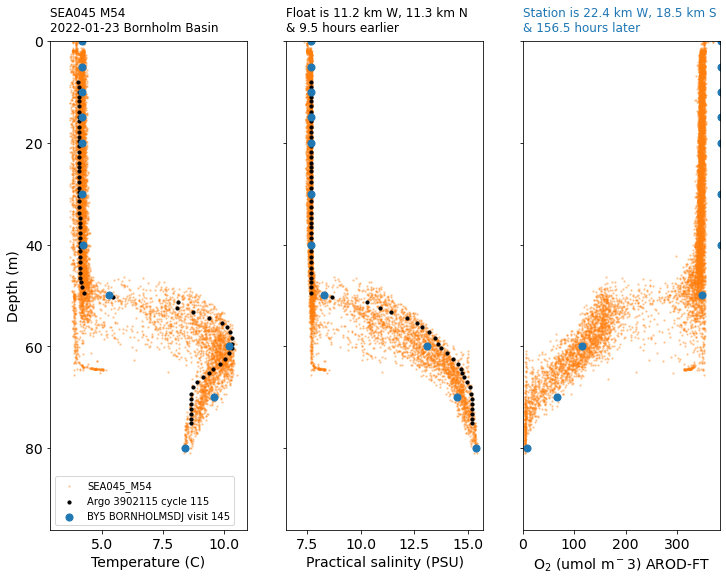

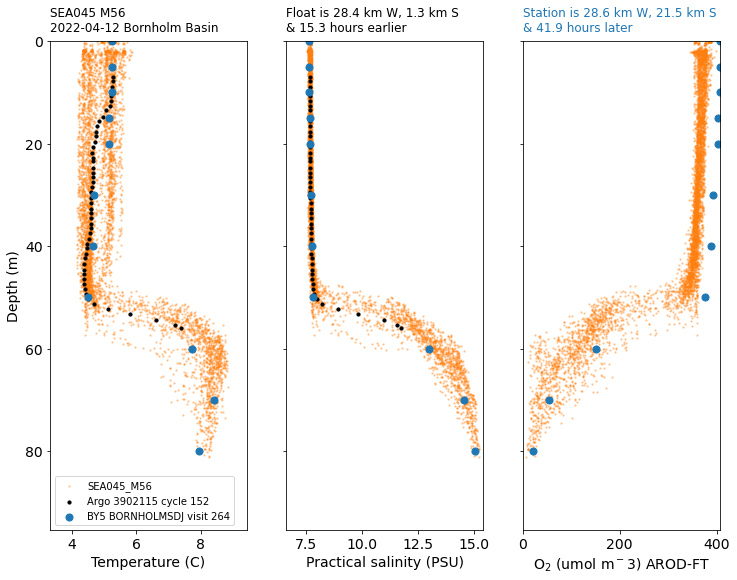

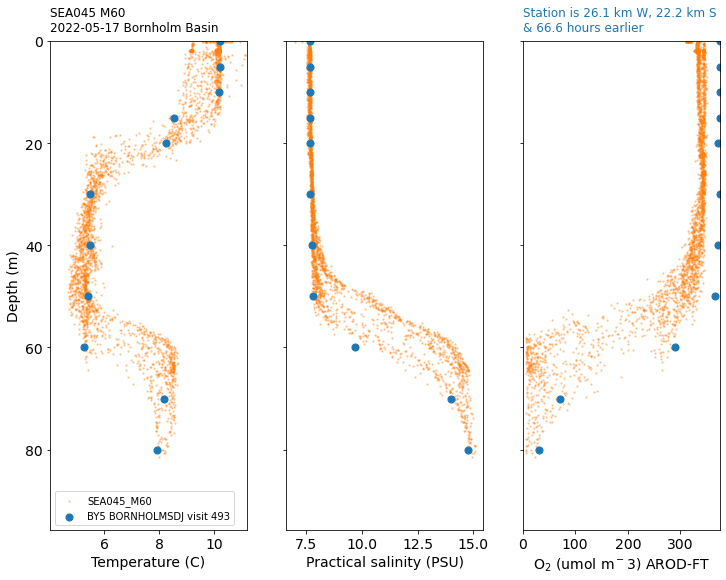

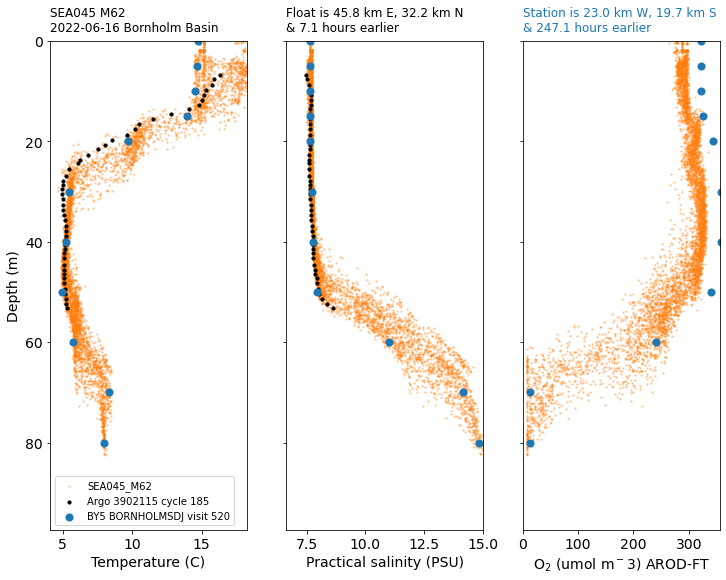

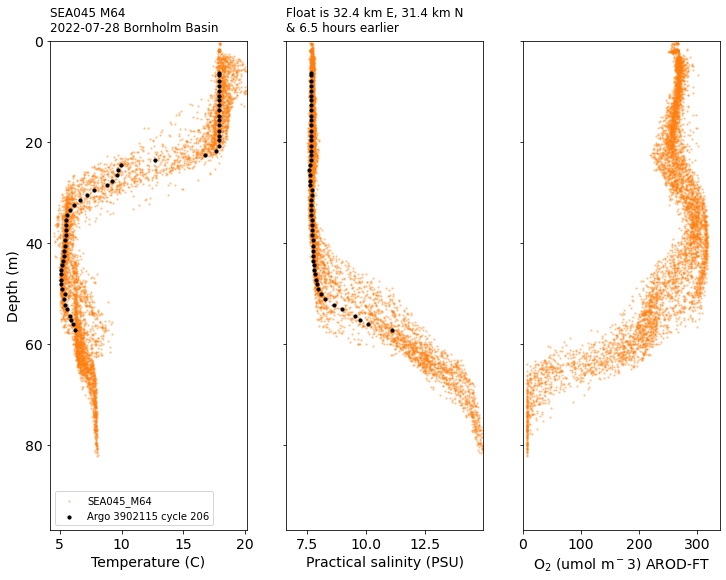

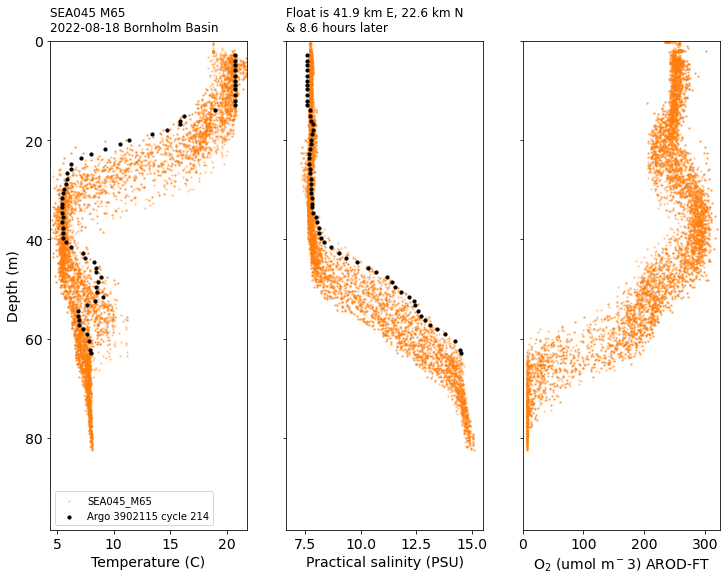

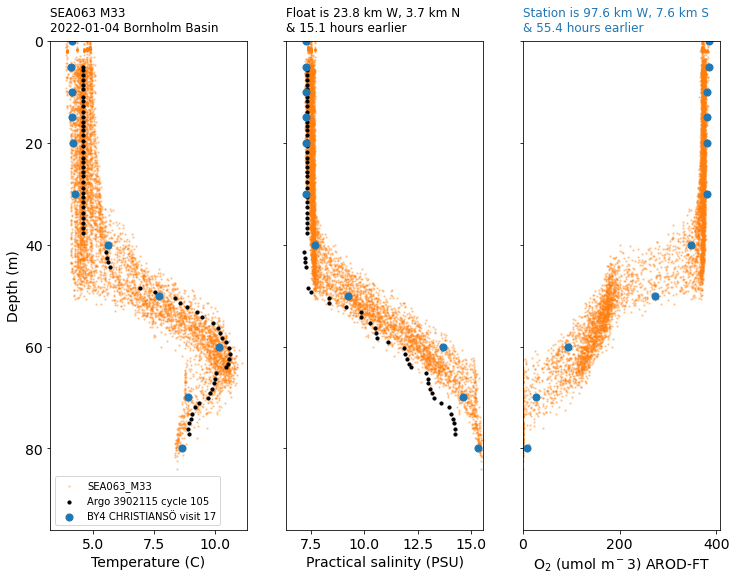

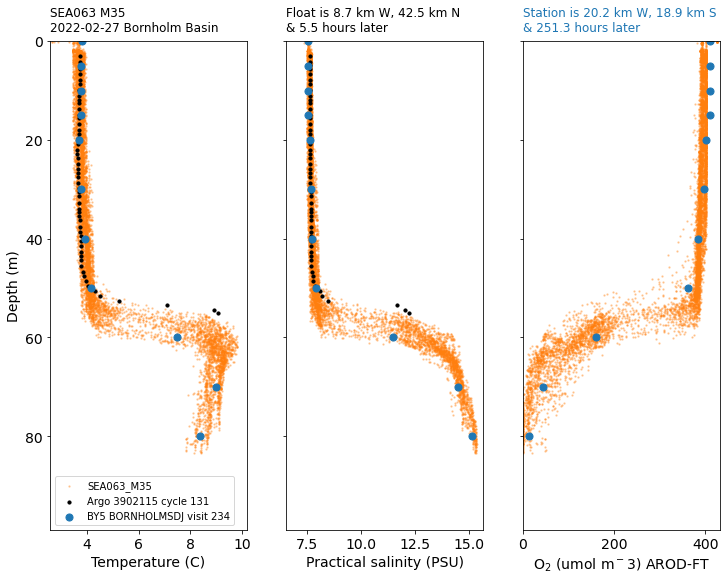

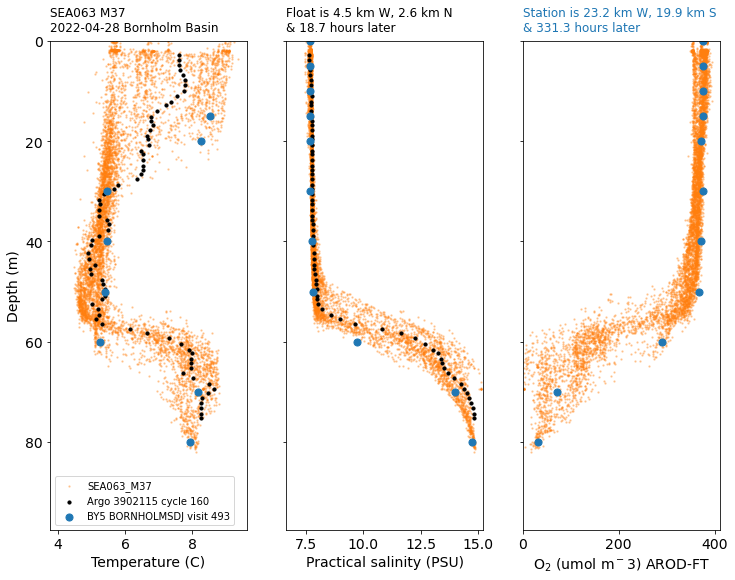

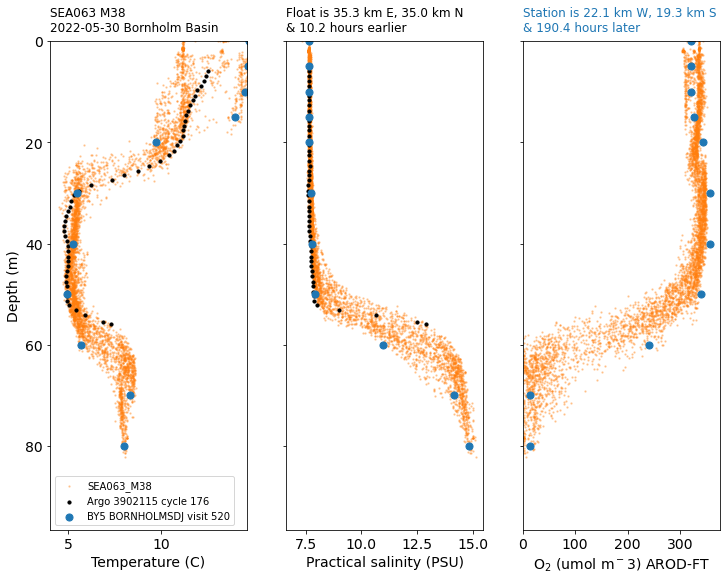

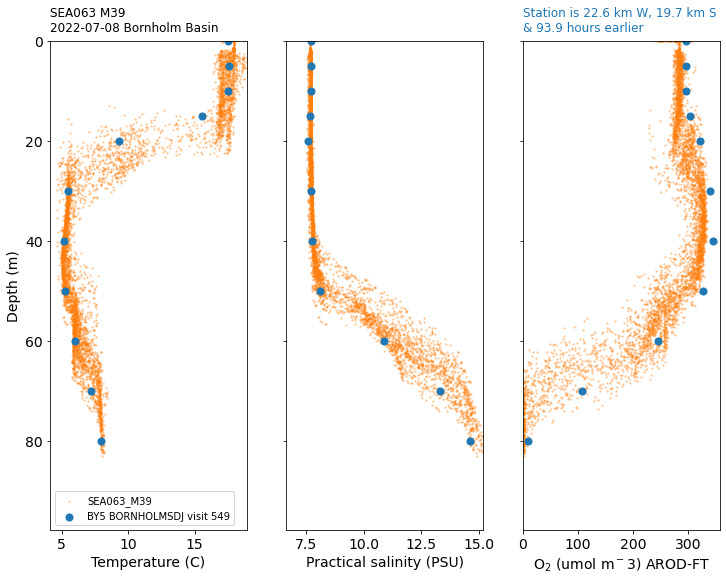

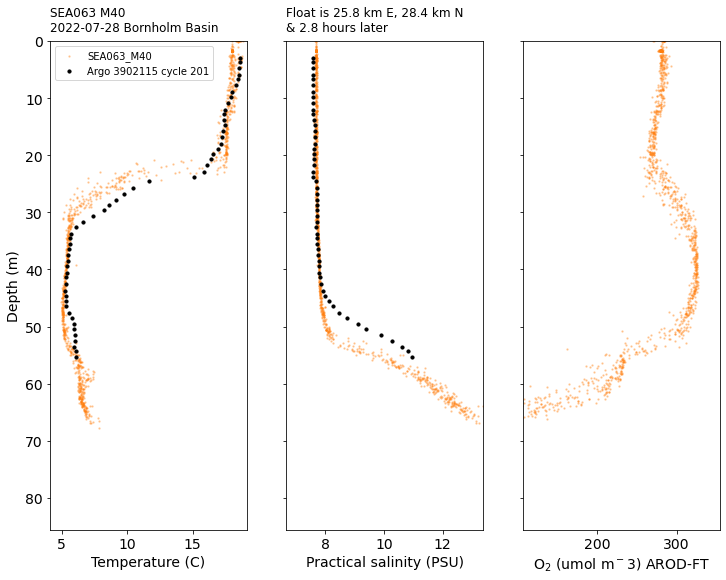

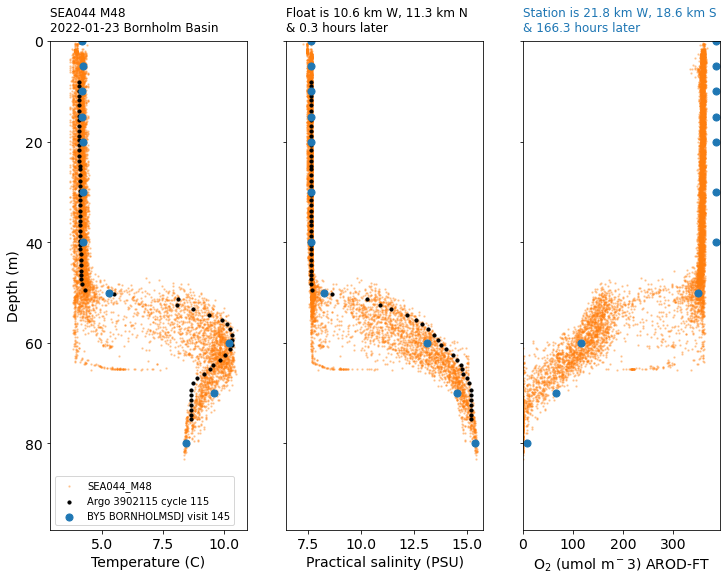

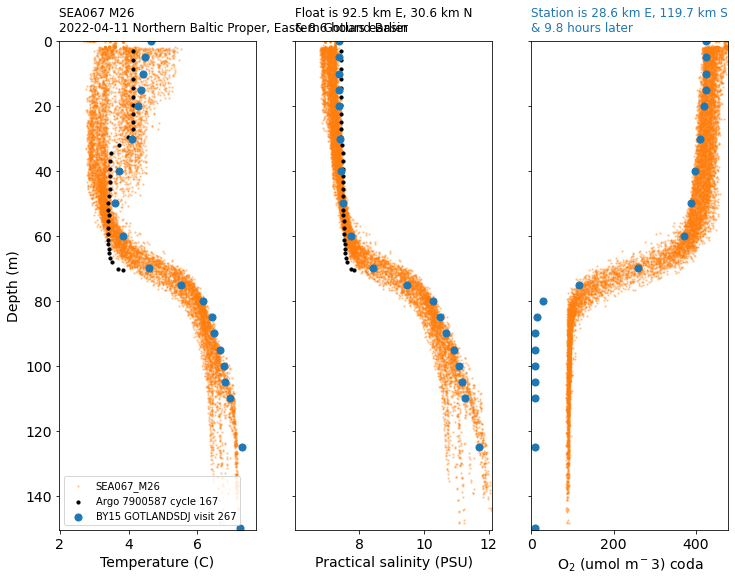

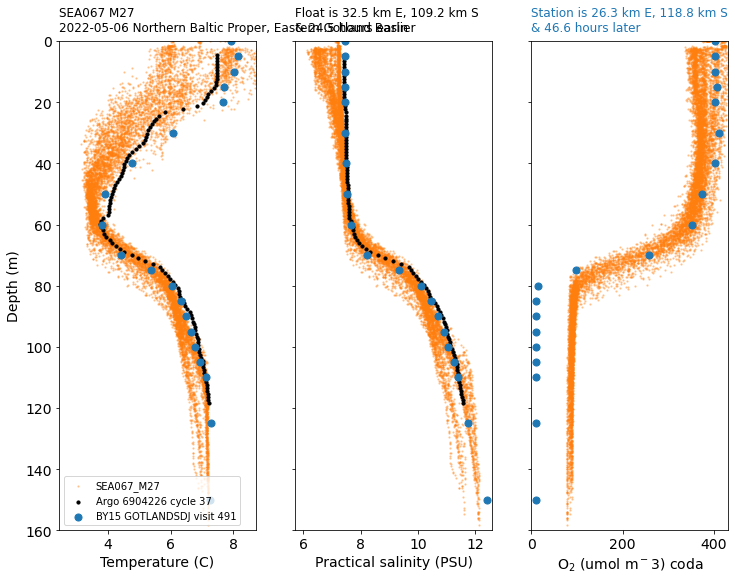

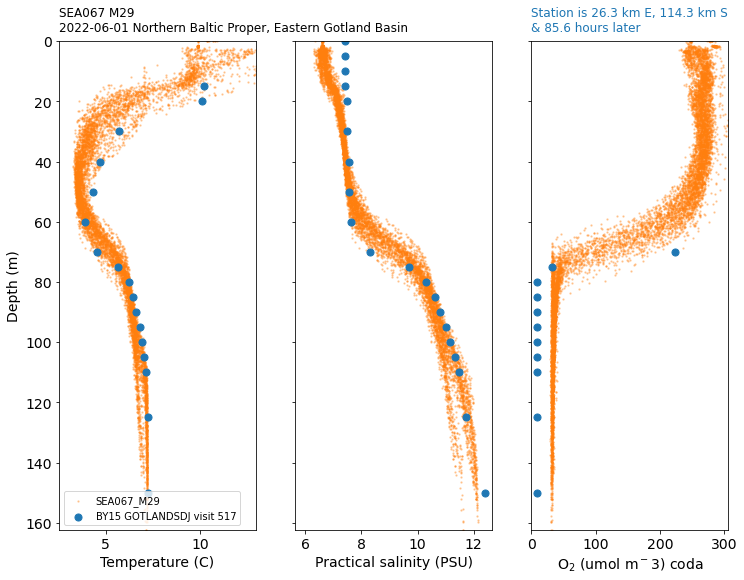

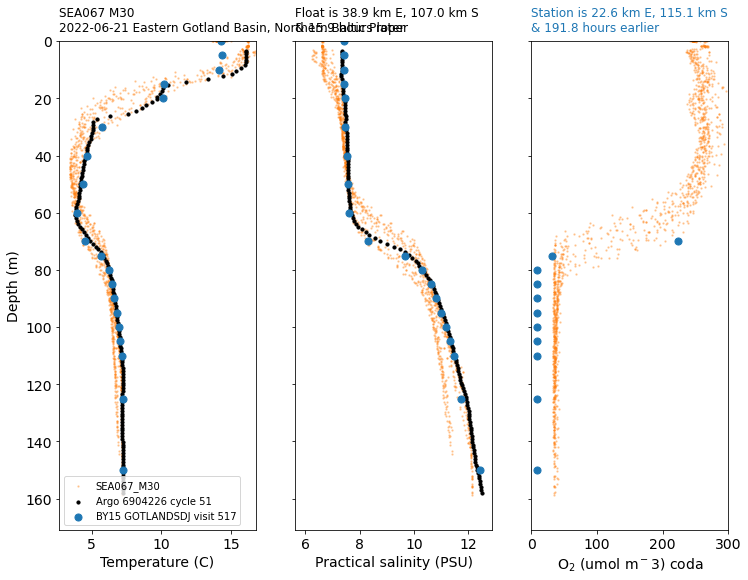

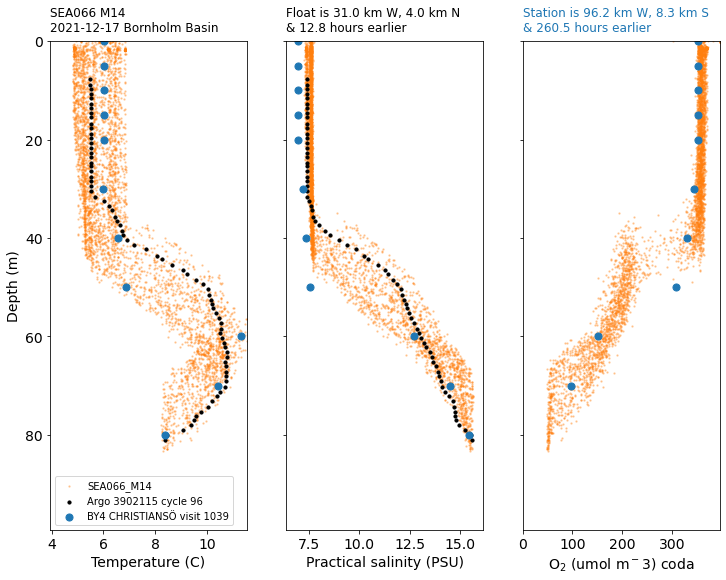

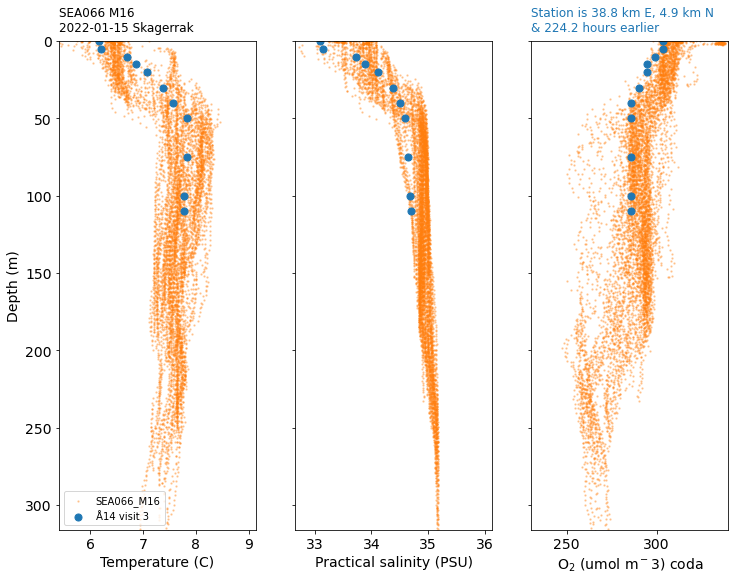

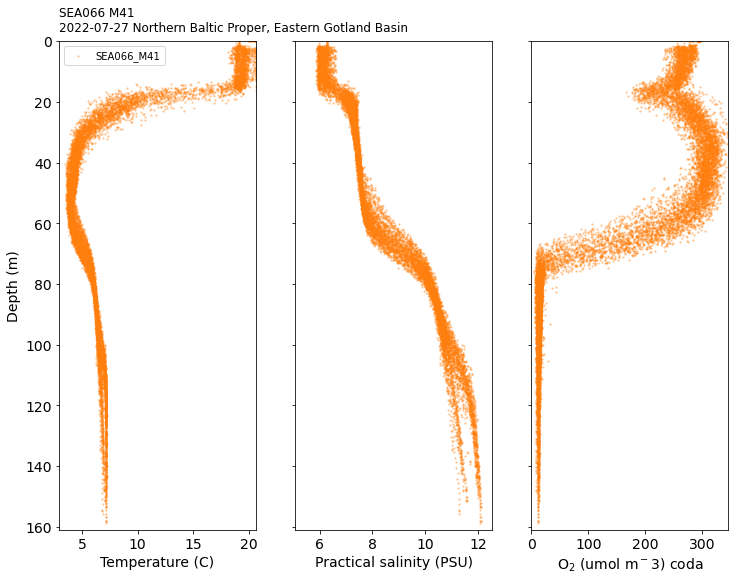

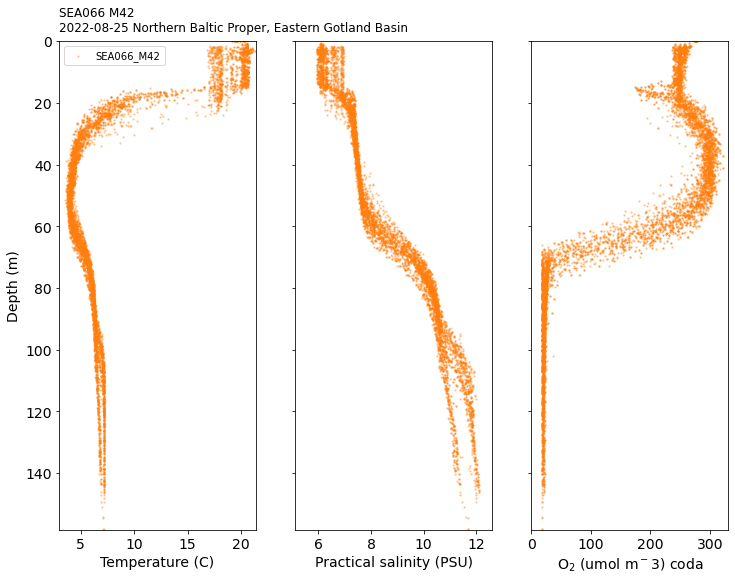

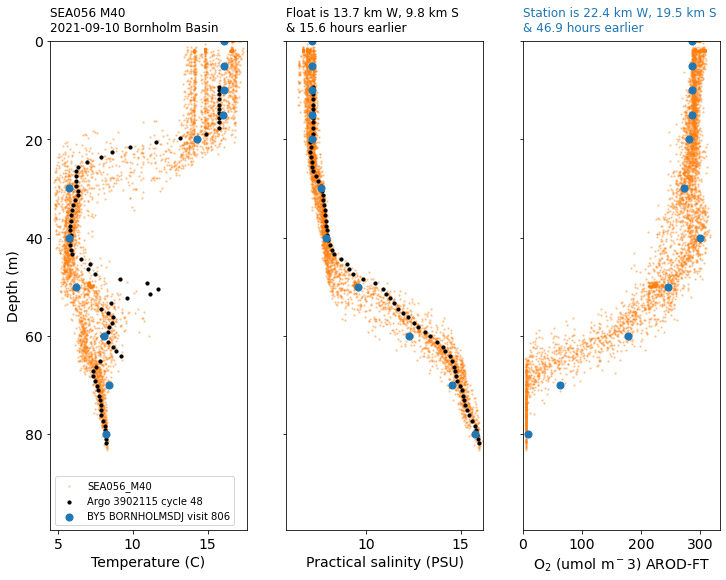

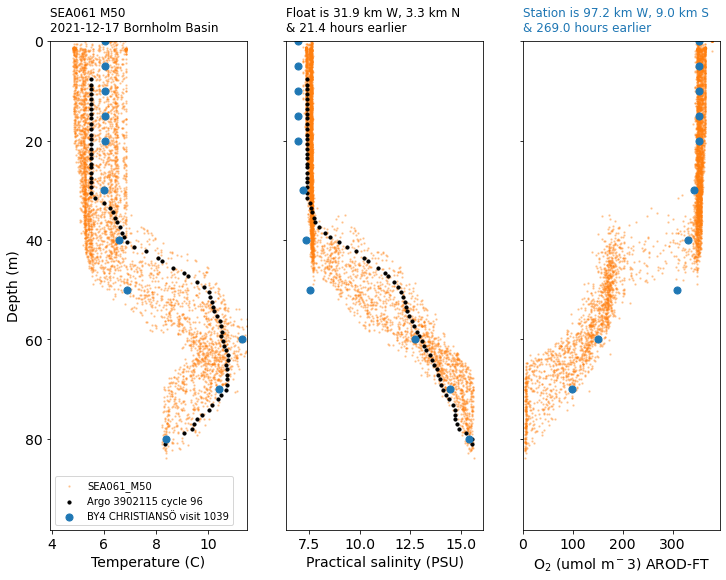

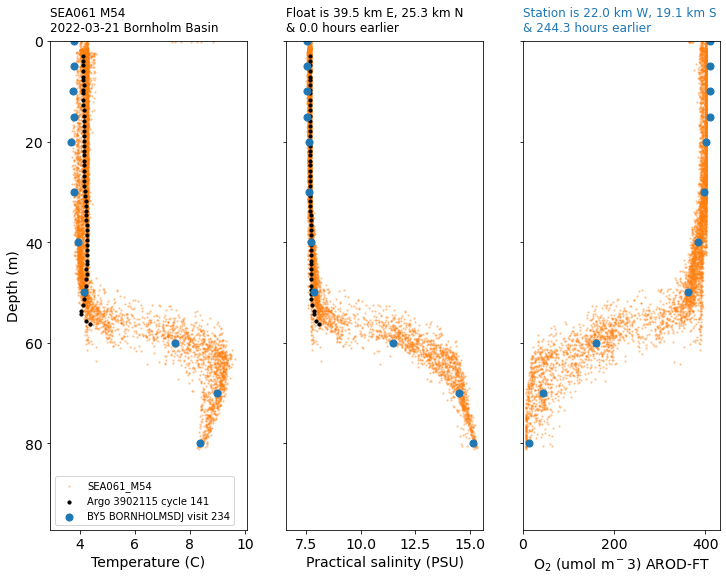

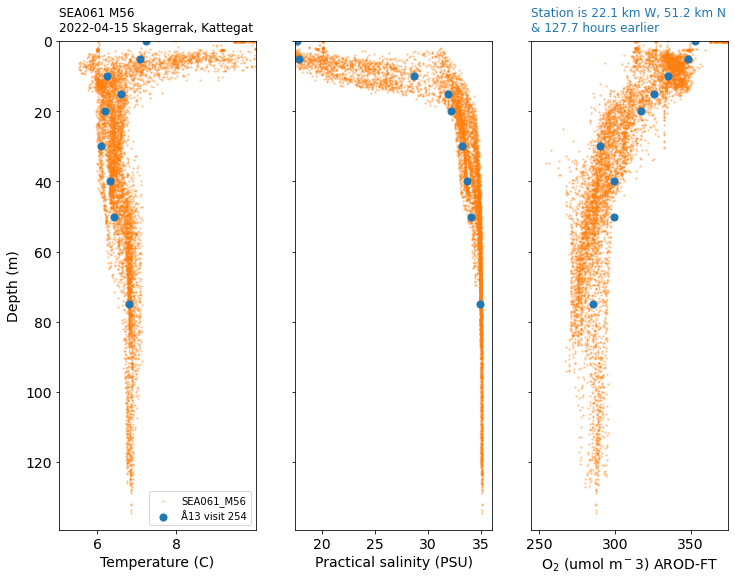

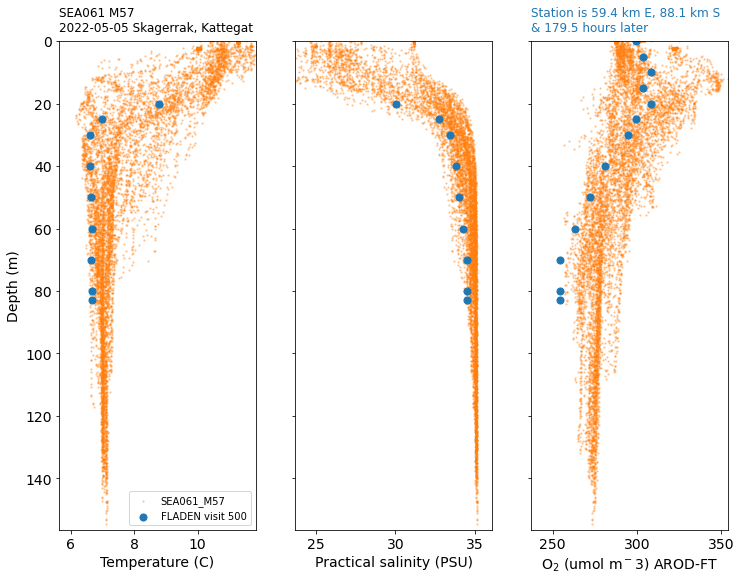

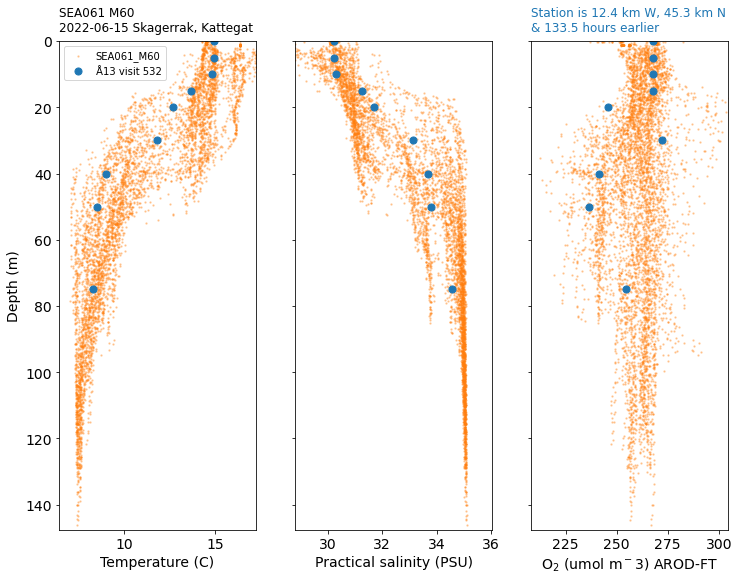

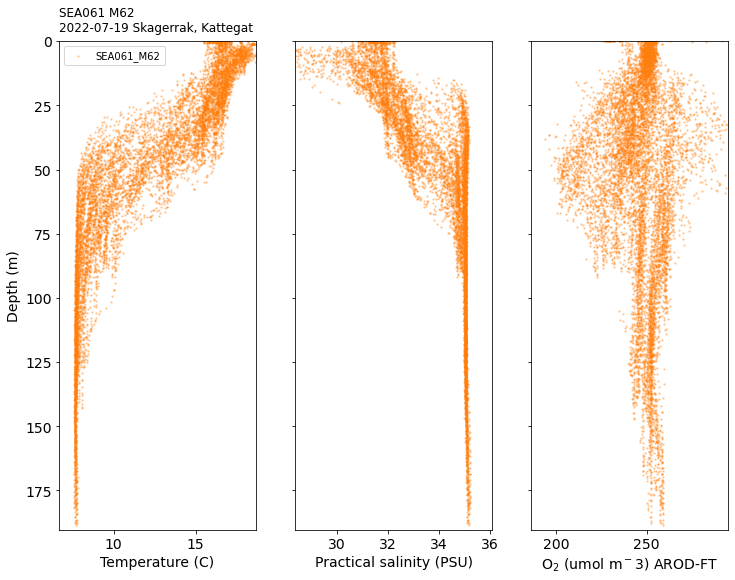

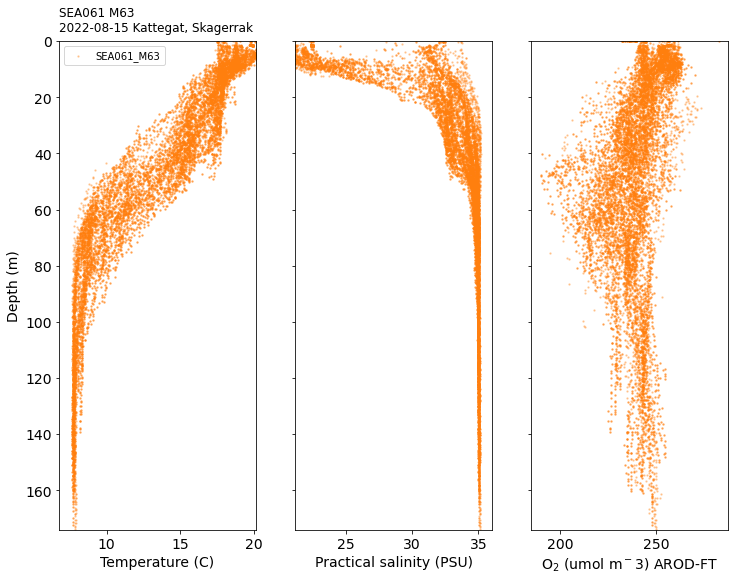

In [11]:
plt.rcParams.update({'font.size': 14})
def compare_scatter(name, ds_glider, ds_argo, df_smhi, span=50):
    """
    Create scatter plots of temperature salinity and dissolved oxygen to visually compare glider and SMHI station data
    """
    glider_kwargs = {"s": 2, "c": "C1", "alpha": 0.3}
    argo_kwargs = {"s": 10, "c": "k"}
    smhi_kwargs = {"s": 50, "c": "C0"}
    fig, ax = plt.subplots(1,3, sharey="row", figsize=(12, 9))
    ax = ax.ravel()
    ylim = [0, np.nanpercentile(ds_glider.depth[ds_glider.depth<1000], 99)+20]
    temp_lim = [np.nanpercentile(ds_glider.temperature,5)-1, np.nanpercentile(ds_glider.temperature,95)+1]
    ax[0].scatter(ds_glider.temperature, ds_glider.depth, label=name[4:], **glider_kwargs)    
    ax[0].set(ylabel="Depth (m)", xlabel="Temperature (C)", xlim=temp_lim, ylim=ylim)
 
    sal_lim = [np.nanpercentile(ds_glider.salinity,5)-1, np.nanpercentile(ds_glider.salinity,95)+1]
    ax[1].scatter(ds_glider.salinity, ds_glider.depth, **glider_kwargs)
    ax[1].set(xlabel="Practical salinity (PSU)", xlim=sal_lim)    
    
    oxy_lim = [np.nanpercentile(ds_glider.oxygen_concentration,5)-30, np.nanpercentile(ds_glider.oxygen_concentration,95)+30]
    if oxy_lim[0] < 100:
        oxy_lim[0] = 0
    ax[2].scatter(ds_glider.oxygen_concentration, ds_glider.depth,**glider_kwargs)
    ax[2].set(xlabel=f'O$_2$ (umol m$^{-3}$) {ast.literal_eval(ds_glider.attrs["oxygen"])["model"]}', xlim=oxy_lim, ylim=ylim)
    

    if ds_argo is not None:
        argo_name = f"Argo {int(ds_argo.PLATFORM_NUMBER)} cycle {int(ds_argo.CYCLE_NUMBER)}"
        ds_argo["DEPTH"] = -gsw.conversions.z_from_p(ds_argo.PRES, ds_argo.LATITUDE.values)
        ax[0].scatter(ds_argo.TEMP, ds_argo.DEPTH, **argo_kwargs, label=argo_name)
        ax[1].scatter(ds_argo.PSAL, ds_argo.DEPTH, **argo_kwargs)

        deg_n = ds_argo.LATITUDE.values - np.nanmean(ds_glider.latitude)
        deg_e = ds_argo.LONGITUDE.values - np.nanmean(ds_glider.longitude)
        ns_ahead = ds_argo.TIME.values - ds_glider.time.mean()
        east_diff, north_diff, time_diff = utils.format_difference(deg_e, deg_n, ns_ahead)
        loc_str = f"Float is {east_diff}, {north_diff}\n& {time_diff}"
        loc_str
        ax[1].text(0, 1.02, loc_str, fontsize=12, transform=ax[1].transAxes)
        
        # closest glider data
        """
        idx_nearest = np.nanargmin(np.abs(ds_glider.time - ds_argo.TIME.values))

        start, stop = idx_nearest - span, idx_nearest + span
        if start < 0:
            start = 0
        if stop > len(ds_glider.obs):
            stop = len(ds_glider.obs)
        glider_argo_sub = ds_glider.loc[dict(obs=slice(start, stop))]
        ax[0].scatter(glider_argo_sub.temperature, glider_argo_sub.depth, color="C2") 
        ax[1].scatter(glider_argo_sub.salinity, glider_argo_sub.depth, color="C2")
        """
        
    if df_smhi is not None:
        smhi_name = f"{df_smhi['Station name'].values[0]} visit {df_smhi['Visit event identifier'].values[0]}"
        df_temp = df_smhi[df_smhi['Parameter']=="Temperature CTD"]
        df_sal = df_smhi[df_smhi['Parameter']=="Salinity CTD"]    
        df_oxy = df_smhi[df_smhi['Parameter']=="Dissolved oxygen O2 CTD"]    
        ax[0].scatter(df_temp["Value"], df_temp['Sampling depth (m)'], **smhi_kwargs, label=smhi_name)
        ax[1].scatter(df_sal["Value"], df_sal['Sampling depth (m)'], **smhi_kwargs)
        ax[2].scatter(oxy_ml_per_l_to_umol_per_m3(df_oxy["Value"]), df_oxy['Sampling depth (m)'], **smhi_kwargs)
        deg_e = df_smhi['Sample longitude (DD)'].values[0] - np.nanmean(ds_glider.longitude)
        deg_n = df_smhi['Sample latitude (DD)'].values[0] - np.nanmean(ds_glider.latitude)
        time_diff = df_smhi['Sampling date'].values[0] - ds_glider.time.mean()
        east_diff, north_diff, time_diff = utils.format_difference(deg_e, deg_n, time_diff)
        loc_str = f"Station is {east_diff}, {north_diff}\n& {time_diff}"
        ax[2].text(0, 1.02, loc_str, fontsize=12, transform=ax[2].transAxes, color="C0")
        
        # closest glider data
        """
        idx_nearest = np.nanargmin(np.abs(ds_glider.time - df_smhi['Sampling date'].values[0]))

        start, stop = idx_nearest - span, idx_nearest + span
        if start < 0:
            start = 0
        if stop > len(ds_glider.obs):
            stop = len(ds_glider.obs)
        glider_smhi_sub = ds_glider.loc[dict(obs=slice(start, stop))]
        ax[0].scatter(glider_smhi_sub.temperature, glider_smhi_sub.depth, color="C4") 
        ax[1].scatter(glider_smhi_sub.salinity, glider_smhi_sub.depth, color="C4")
        ax[2].scatter(glider_smhi_sub.oxygen_concentration, glider_smhi_sub.depth, color="C4")
        """
    # final touches
    attrs = ds_glider.attrs
    glider_str = f'SEA0{attrs["glider_serial"]} M{attrs["deployment_id"]}\n{attrs["deployment_start"][:10]} {attrs["basin"]}'
    ax[0].text(0, 1.02, glider_str, fontsize=12, transform=ax[0].transAxes)
    ax[0].invert_yaxis()
    ax[0].legend(fontsize=10)
    
    
    plt.savefig(f"figures/compare_{name}.png")
    #plt.close("all")

for name in dataset_match_df.index:
    compare_scatter(name, glider_datasets[name], argo_datasets[name], smhi_datasets[name])

In [12]:
name = "nrt_SEA068_M27"
glider = glider_datasets[name]
argo = argo_datasets[name]
smhi =smhi_datasets[name]

In [13]:
glider

<xarray.Dataset>
Dimensions:               (timeseries: 73, obs: 4052)
Coordinates:
    depth                 (obs) float64 -0.09025 -0.0851 -0.085 ... 11.37 8.75
    latitude              (obs) float64 58.26 58.26 58.26 ... 58.22 58.22 58.22
    longitude             (obs) float64 19.96 19.96 19.96 ... 19.92 19.92 19.92
    time                  (obs) datetime64[ns] 2022-07-27T17:09:41.686000128 ...
Dimensions without coordinates: timeseries, obs
Data variables:
    profile_index         (timeseries) float64 ...
    rowSize               (timeseries) int32 ...
    salinity              (obs) float64 nan nan nan nan ... 6.648 6.654 6.611
    temperature           (obs) float64 18.08 18.03 17.99 ... 18.81 18.84 19.0
    pressure              (obs) float64 -0.0911 -0.0859 -0.0858 ... 11.48 8.832
    oxygen_concentration  (obs) float64 273.3 273.8 273.8 ... 245.8 250.0 257.7
    chlorophyll           (obs) float64 ...
Attributes: (12/72)
    acknowledgement:               This study used data collected and made fr...
    basin:                         Eastern Gotland Basin
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      profile_index
    comment:                       deployment and recovery in Skagerrak
    contributor_name:              Callum Rollo, Louise Biddle, Olle Petersso...
    ...                            ...
    time_coverage_end:             2022-07-31T02:47:09Z
    time_coverage_start:           2022-07-27T17:09:41Z
    title:                         Aster68-20220727T1709
    transmission_system:           IRIDIUM
    Westernmost_Easting:           19.901883333333334
    wmo_id:                        6801602